# V.7
- ResNet
- 예측이 잘 안 되는 데이터만 사용한 모델 -> [3, 4, 7]
- 데이터 불러올 때 증강 사용

In [1]:
import pandas as pd
import numpy as np
import os
import time
import random
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import timm
import torch
import albumentations as A
import torch.nn as nn
from albumentations.pytorch import ToTensorV2
from torch.optim import Adam
from torchvision import transforms
import torchvision.transforms as T
from torch.utils.data import Dataset, DataLoader
from augraphy import *

from sklearn.metrics import accuracy_score, f1_score

import wandb

import warnings
warnings.filterwarnings("ignore")

In [2]:
# 시드를 고정합니다.
SEED = 42
os.environ['PYTHONHASHSEED'] = str(SEED)
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
device

device(type='cuda')

# CustomDataset

In [5]:
train_df = pd.read_csv('/data/ephemeral/home/data/train.csv')
train_df

,ID,target
0,002f99746285dfdd.jpg,16
1,008ccd231e1fea5d.jpg,10
2,008f5911bfda7695.jpg,10
3,009235e4c9c07af5.jpg,4
4,00b2f44967580c74.jpg,16
...,...,...
1565,fed9e9ec4a77bc06.jpg,4
1566,feeade617aa68c45.jpg,7
1567,ff51dd281a8423f1.jpg,11
1568,ff8a6a251ce51c95.jpg,5


In [6]:
train_df = train_df[(train_df['target']==3) | (train_df['target']==4) | (train_df['target']==7)]

In [7]:
mapping = {3:0, 4:1, 7:2}

train_df['target'] = train_df['target'].map(mapping)
train_df

,ID,target
3,009235e4c9c07af5.jpg,1
15,0250ee8107091ade.jpg,2
20,02dad82a9420ae86.jpg,2
24,03084c1b03921a99.jpg,2
39,05c30f3c5be4bdcb.jpg,0
...,...,...
1559,fe30845b79d1d42f.jpg,2
1560,fe73481aadfbec34.jpg,0
1563,fe9683317086dbab.jpg,0
1565,fed9e9ec4a77bc06.jpg,1


In [8]:
train_df.to_csv('/data/ephemeral/home/data/train_for_v7.csv', index=False)

In [9]:
class customdataset(torch.utils.data.Dataset):
    def __init__(self, csv, path, transforms):
        super().__init__()
        self.df = pd.read_csv(csv).values
        self.path = path
        self.transforms = transforms

    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        name, target = self.df[idx]
        img = np.array(Image.open(os.path.join(self.path, name)))
        img = self.transforms(img)
    
        return img, target

In [10]:
class RandomPadding:
    def __init__(self, padding_range=(0, 50), fill=0):
        self.padding_range = padding_range
        self.fill = fill

    def __call__(self, image):
        # 각 방향에 대해 랜덤한 패딩 값 생성
        pad_top = random.randint(*self.padding_range)
        pad_bottom = random.randint(*self.padding_range)
        pad_left = random.randint(*self.padding_range)
        pad_right = random.randint(*self.padding_range)
        
        # 패딩 추가
        padding = (pad_left, pad_top, pad_right, pad_bottom)
        return T.functional.pad(image, padding, fill=self.fill)

In [11]:
aug_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    RandomPadding(padding_range=(10, 20), fill=50),  # 랜덤 패딩 추가
    T.RandomResizedCrop(size=(550,550), scale=(0.5, 1.0)),
    T.Resize((600, 600))
])

simple_transforms = T.Compose([
    T.ToTensor(),
    T.RandomRotation(180),
    T.RandomHorizontalFlip(p=0.5),
    T.Resize((600, 600))
])

origin_transforms = T.Compose([
    T.ToTensor(),
    T.Resize((600, 600))])

In [12]:
aug_dataset_1 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented1', transforms=aug_transforms)
aug_dataset_2 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented2', transforms=aug_transforms)
aug_dataset_3 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented3', transforms=aug_transforms)
aug_dataset_4 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented4', transforms=aug_transforms)
aug_dataset_5 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented5', transforms=aug_transforms)
aug_dataset_6 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/Augmentation/augraphy2/augmented6', transforms=aug_transforms)

simple_aug_dataset_1 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_2 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)
simple_aug_dataset_3 = customdataset('/data/ephemeral/home/data/train_for_v7.csv', '/data/ephemeral/home/data/train/', transforms=simple_transforms)

In [13]:
train_dataset = torch.utils.data.ConcatDataset([aug_dataset_1, aug_dataset_2, aug_dataset_3, 
                                                aug_dataset_4, aug_dataset_5, aug_dataset_6,
                                                
                                                simple_aug_dataset_1, simple_aug_dataset_2, simple_aug_dataset_3])

In [14]:
len(train_dataset)

2700

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..50.0].


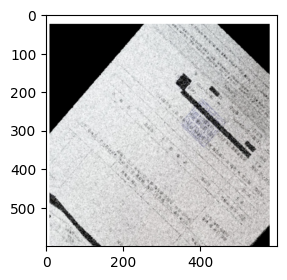

In [15]:
plt.figure(figsize=(3, 3))
plt.imshow(train_dataset[600][0].permute(1, 2, 0))
plt.show()

# valid dataset

### train data 중 일부 사용

In [16]:
total_num = len(train_dataset)
train_num, valid_num = int(total_num*0.9), int(total_num*0.1)

train_dataset, valid_dataset = torch.utils.data.random_split(train_dataset, [train_num, valid_num])

In [17]:
print(len(train_dataset), len(valid_dataset))

2430 270


In [18]:
batch_size = 32

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size, shuffle=True, num_workers=16)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size, shuffle=False, num_workers=16)

# 학습

### 학습전 모델 이름 바꿔주기!!

In [19]:
def training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs):
    model.train()
    train_loss = 0.0
    train_accuracy = 0

    tbar = tqdm(train_dataloader)
    for images, labels in tbar:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        max_prob, predicted = torch.max(outputs, 1)
        train_accuracy += (predicted == labels).sum().item()

        tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Train Loss: {loss.item():.4f}')

    train_loss = train_loss / len(train_dataloader)
    train_accuracy = train_accuracy / len(train_dataset)

    return model, train_loss, train_accuracy

def evalutaion(model, valid_dataloader, valid_accuracy, criterion, epoch, num_epochs):
    model.eval()
    valid_loss = 0.0
    valid_accuracy = 0

    with torch.no_grad():
        tbar = tqdm(valid_dataloader)
        for images, labels in tbar:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)

            valid_loss += loss.item()
            max_prob, predicted = torch.max(outputs, 1)
            valid_accuracy += (predicted == labels).sum().item()

            tbar.set_description(f'Epoch/Epochs [{epoch+1}/{num_epochs}], Valid Loss: {loss.item():.4f}')

    valid_loss = valid_loss / len(valid_dataloader)
    valid_accuracy = valid_accuracy / len(valid_dataset)

    return model, valid_loss, valid_accuracy

def training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, num_epochs):
    best_valid_loss = float('inf')
    early_stop_cnt = 0
    valid_max_accuracy = -1

    for epoch in range(num_epochs):
        model, train_loss, train_accuracy = training(model, train_dataloader, train_dataset, criterion, optimizer, epoch, num_epochs)
        model, valid_loss, valid_accuracy = evalutaion(model, valid_dataloader, valid_dataset, criterion, epoch, num_epochs)

        #monitoring_values = {'Train Loss': train_loss, 'Valid Loss': valid_loss, 'Train Accuracy': train_accuracy, 'Valid Accuracy': valid_accuracy}
        #run.log(monitoring_values, step=epoch)

        if valid_accuracy > valid_max_accuracy:
            valid_max_accuracy = valid_accuracy

        if valid_loss < best_valid_loss:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v7_2_best.pt")
            best_valid_loss = valid_loss
            early_stop_cnt = 0

        else :
            early_stop_cnt += 1

        print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f} Valid Loss: {valid_loss:.4f}, Valid Accuracy: {valid_accuracy:.4f}")

        if early_stop_cnt >= 20:
            torch.save(model.state_dict(), f"/data/ephemeral/home/model/models/model_v7_2_last.pt")
            print('Early Stopping')
            break

    return model

In [20]:
model = timm.create_model(
    'resnet50',
    pretrained=True,
    num_classes=3
).to(device)

criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [21]:
print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (act1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (drop_block): Identity()
      (act2): ReLU(inplace=True)
      (aa): Identity()
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
     

In [22]:
model = training_loop(model, train_dataloader, train_dataset, valid_dataloader, valid_dataset, criterion, optimizer, 100)

  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [1/100], Train Loss: 1.0977, Train Accuracy: 0.3399 Valid Loss: 1.0951, Valid Accuracy: 0.3556


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [2/100], Train Loss: 1.0813, Train Accuracy: 0.3922 Valid Loss: 1.0369, Valid Accuracy: 0.4815


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [3/100], Train Loss: 0.9511, Train Accuracy: 0.5296 Valid Loss: 1.9935, Valid Accuracy: 0.3000


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [4/100], Train Loss: 0.8235, Train Accuracy: 0.5979 Valid Loss: 2.9757, Valid Accuracy: 0.3074


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [5/100], Train Loss: 0.7183, Train Accuracy: 0.6687 Valid Loss: 1.0382, Valid Accuracy: 0.4926


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [6/100], Train Loss: 0.6149, Train Accuracy: 0.7095 Valid Loss: 1.0780, Valid Accuracy: 0.5963


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [7/100], Train Loss: 0.5790, Train Accuracy: 0.7444 Valid Loss: 0.7729, Valid Accuracy: 0.6593


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [8/100], Train Loss: 0.4947, Train Accuracy: 0.7757 Valid Loss: 3.3810, Valid Accuracy: 0.3074


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [9/100], Train Loss: 0.4708, Train Accuracy: 0.8041 Valid Loss: 1.8426, Valid Accuracy: 0.4185


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [10/100], Train Loss: 0.4215, Train Accuracy: 0.8329 Valid Loss: 0.8480, Valid Accuracy: 0.6370


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [11/100], Train Loss: 0.3433, Train Accuracy: 0.8588 Valid Loss: 2.7669, Valid Accuracy: 0.4000


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [12/100], Train Loss: 0.3171, Train Accuracy: 0.8724 Valid Loss: 6.8274, Valid Accuracy: 0.3148


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [13/100], Train Loss: 0.2871, Train Accuracy: 0.8872 Valid Loss: 0.7961, Valid Accuracy: 0.7037


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [14/100], Train Loss: 0.2464, Train Accuracy: 0.9016 Valid Loss: 1.7234, Valid Accuracy: 0.4333


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [15/100], Train Loss: 0.2279, Train Accuracy: 0.9160 Valid Loss: 0.5399, Valid Accuracy: 0.7815


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [16/100], Train Loss: 0.2126, Train Accuracy: 0.9198 Valid Loss: 1.5523, Valid Accuracy: 0.5037


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [17/100], Train Loss: 0.1761, Train Accuracy: 0.9358 Valid Loss: 1.0125, Valid Accuracy: 0.6000


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [18/100], Train Loss: 0.1828, Train Accuracy: 0.9300 Valid Loss: 1.1842, Valid Accuracy: 0.5407


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [19/100], Train Loss: 0.1554, Train Accuracy: 0.9453 Valid Loss: 1.1656, Valid Accuracy: 0.6852


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [20/100], Train Loss: 0.1310, Train Accuracy: 0.9527 Valid Loss: 2.5237, Valid Accuracy: 0.5259


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [21/100], Train Loss: 0.1304, Train Accuracy: 0.9560 Valid Loss: 2.4858, Valid Accuracy: 0.5889


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [22/100], Train Loss: 0.1108, Train Accuracy: 0.9564 Valid Loss: 1.4942, Valid Accuracy: 0.5556


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [23/100], Train Loss: 0.1038, Train Accuracy: 0.9564 Valid Loss: 2.3708, Valid Accuracy: 0.5333


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [24/100], Train Loss: 0.1156, Train Accuracy: 0.9605 Valid Loss: 0.3059, Valid Accuracy: 0.8778


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [25/100], Train Loss: 0.1035, Train Accuracy: 0.9675 Valid Loss: 1.7664, Valid Accuracy: 0.5926


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [26/100], Train Loss: 0.1045, Train Accuracy: 0.9621 Valid Loss: 1.0479, Valid Accuracy: 0.7370


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [27/100], Train Loss: 0.0861, Train Accuracy: 0.9683 Valid Loss: 2.8235, Valid Accuracy: 0.5481


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [28/100], Train Loss: 0.1002, Train Accuracy: 0.9638 Valid Loss: 0.9843, Valid Accuracy: 0.6333


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [29/100], Train Loss: 0.0962, Train Accuracy: 0.9654 Valid Loss: 1.2982, Valid Accuracy: 0.6185


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [30/100], Train Loss: 0.0759, Train Accuracy: 0.9724 Valid Loss: 0.4310, Valid Accuracy: 0.8704


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [31/100], Train Loss: 0.0434, Train Accuracy: 0.9864 Valid Loss: 1.0407, Valid Accuracy: 0.7963


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [32/100], Train Loss: 0.0714, Train Accuracy: 0.9761 Valid Loss: 0.4522, Valid Accuracy: 0.8630


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [33/100], Train Loss: 0.0725, Train Accuracy: 0.9741 Valid Loss: 1.8173, Valid Accuracy: 0.5185


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [34/100], Train Loss: 0.0689, Train Accuracy: 0.9761 Valid Loss: 0.3264, Valid Accuracy: 0.8852


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [35/100], Train Loss: 0.0703, Train Accuracy: 0.9765 Valid Loss: 0.5837, Valid Accuracy: 0.8185


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [36/100], Train Loss: 0.0797, Train Accuracy: 0.9720 Valid Loss: 0.8849, Valid Accuracy: 0.7852


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [37/100], Train Loss: 0.0702, Train Accuracy: 0.9749 Valid Loss: 1.4407, Valid Accuracy: 0.6444


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [38/100], Train Loss: 0.1072, Train Accuracy: 0.9634 Valid Loss: 3.1397, Valid Accuracy: 0.4889


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [39/100], Train Loss: 0.0608, Train Accuracy: 0.9786 Valid Loss: 0.3967, Valid Accuracy: 0.8963


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [40/100], Train Loss: 0.0430, Train Accuracy: 0.9864 Valid Loss: 0.7613, Valid Accuracy: 0.8148


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [41/100], Train Loss: 0.0491, Train Accuracy: 0.9860 Valid Loss: 1.9908, Valid Accuracy: 0.5741


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [42/100], Train Loss: 0.0383, Train Accuracy: 0.9881 Valid Loss: 2.1827, Valid Accuracy: 0.6222


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [43/100], Train Loss: 0.0291, Train Accuracy: 0.9909 Valid Loss: 0.0306, Valid Accuracy: 0.9926


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [44/100], Train Loss: 0.0360, Train Accuracy: 0.9893 Valid Loss: 1.3991, Valid Accuracy: 0.7148


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [45/100], Train Loss: 0.0401, Train Accuracy: 0.9852 Valid Loss: 0.2427, Valid Accuracy: 0.9074


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [46/100], Train Loss: 0.0554, Train Accuracy: 0.9811 Valid Loss: 1.0508, Valid Accuracy: 0.7222


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [47/100], Train Loss: 0.0674, Train Accuracy: 0.9794 Valid Loss: 0.9231, Valid Accuracy: 0.7852


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [48/100], Train Loss: 0.0557, Train Accuracy: 0.9823 Valid Loss: 0.4807, Valid Accuracy: 0.8444


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [49/100], Train Loss: 0.0473, Train Accuracy: 0.9856 Valid Loss: 1.5920, Valid Accuracy: 0.7148


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [50/100], Train Loss: 0.0526, Train Accuracy: 0.9827 Valid Loss: 3.8928, Valid Accuracy: 0.4593


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [51/100], Train Loss: 0.0479, Train Accuracy: 0.9835 Valid Loss: 1.2144, Valid Accuracy: 0.7185


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [52/100], Train Loss: 0.0626, Train Accuracy: 0.9790 Valid Loss: 4.4066, Valid Accuracy: 0.4593


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [53/100], Train Loss: 0.0694, Train Accuracy: 0.9741 Valid Loss: 0.1897, Valid Accuracy: 0.9222


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [54/100], Train Loss: 0.0412, Train Accuracy: 0.9877 Valid Loss: 1.4443, Valid Accuracy: 0.7667


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [55/100], Train Loss: 0.0368, Train Accuracy: 0.9860 Valid Loss: 1.0729, Valid Accuracy: 0.7519


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [56/100], Train Loss: 0.0315, Train Accuracy: 0.9893 Valid Loss: 0.5357, Valid Accuracy: 0.8519


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [57/100], Train Loss: 0.0431, Train Accuracy: 0.9877 Valid Loss: 5.8159, Valid Accuracy: 0.3778


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [58/100], Train Loss: 0.0384, Train Accuracy: 0.9877 Valid Loss: 0.4723, Valid Accuracy: 0.8667


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [59/100], Train Loss: 0.0373, Train Accuracy: 0.9885 Valid Loss: 1.7836, Valid Accuracy: 0.6852


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [60/100], Train Loss: 0.0795, Train Accuracy: 0.9728 Valid Loss: 1.6226, Valid Accuracy: 0.6333


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [61/100], Train Loss: 0.0472, Train Accuracy: 0.9844 Valid Loss: 3.4771, Valid Accuracy: 0.5926


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [62/100], Train Loss: 0.0491, Train Accuracy: 0.9844 Valid Loss: 2.4331, Valid Accuracy: 0.6556


  0%|          | 0/76 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch [63/100], Train Loss: 0.0562, Train Accuracy: 0.9815 Valid Loss: 0.6145, Valid Accuracy: 0.8556
Early Stopping
